## SVM
We have subjected the signals from https://www.sciencedirect.com/science/article/pii/S2352340918314124 to certain transformations to preprocess them: 
* In order to have more training data, each signal capture (of duration 10 seconds), we have divided it into 10 signals of 1s each (numerous studies show that with less than 1s of vibration, faults in the signals can be appreciated).
* Each signal captured every 1s was multiplied by a Hamming-type window function.
* After applying the window function, the signals were subjected to a low pass band filter.

For each preprocessed signal, we calculated 8 statistics and/or significant parameters for diagnosis: Kurtosis, Impulse factor, RMS, Margin factor, Skewness, Shape factor, Peak to peak, Crest factor. We will apply SVM for classification, using these statistics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
import joblib 

In [2]:
df_train = pd.read_csv("statistics_10_train.csv" , sep = ',')
df_test = pd.read_csv("statistics_10_test.csv" , sep = ',')

In [3]:
X_train = df_train[['Kurtosis', 'Impulse factor', 'RMS', 'Margin factor', 'Skewness',
               'Shape factor', 'Peak to peak', 'Crest factor']].values
y_train = df_train['Tipo'].values
X_test = df_test[['Kurtosis', 'Impulse factor', 'RMS', 'Margin factor', 'Skewness',
               'Shape factor', 'Peak to peak', 'Crest factor']].values
y_test = df_test['Tipo'].values

#### We trained an SVM on the training data. We search for optimal parameters using GridSearchCV.

In [4]:
from time import time

t0 = time()
print("Fitting the classifier to the training set...")
param_grid = {'C': [1E2, 5E2, 1E3, 5E3, 1E4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

print("Elapsed time: %0.3fs"%(time() - t0))
print("Best estimator found by grid search:")
print(grid.best_params_)

Fitting the classifier to the training set...
Elapsed time: 0.249s
Best estimator found by grid search:
{'C': 500.0, 'gamma': 0.01}


#### We predict in the test and report the classification results obtained:

In [5]:
y_pred = clf.predict(X_test)

In [6]:
target_names = ['Inner', 'Outer', 'Healthy']
print(classification_report(y_test, y_pred, target_names = target_names))

              precision    recall  f1-score   support

       Inner       0.97      1.00      0.98        30
       Outer       0.93      0.93      0.93        30
     Healthy       0.97      0.93      0.95        30

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90



In [7]:
print(confusion_matrix(y_test, y_pred))

[[30  0  0]
 [ 1 28  1]
 [ 0  2 28]]


In [8]:
pred_train = clf.predict(X_train)
print(classification_report(y_train, pred_train, target_names = target_names))

              precision    recall  f1-score   support

       Inner       1.00      1.00      1.00        90
       Outer       1.00      1.00      1.00        90
     Healthy       1.00      1.00      1.00        90

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



In [9]:
print(confusion_matrix(y_train, pred_train))

[[90  0  0]
 [ 0 90  0]
 [ 0  0 90]]


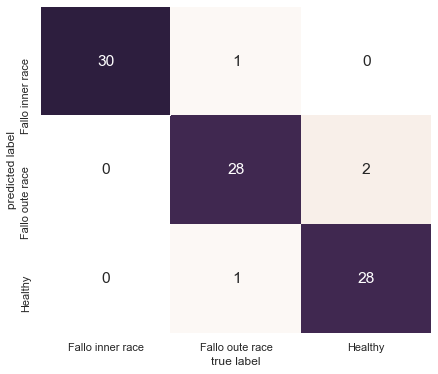

In [10]:
sns.set()
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7,6))
sns.set(font_scale=1.3)
sns.heatmap(mat.T, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=['Fallo inner race', 'Fallo oute race', 'Healthy'],
            yticklabels=['Fallo inner race', 'Fallo oute race', 'Healthy'],
            cmap=sns.cubehelix_palette(light=1, as_cmap=True))

plt.xlabel('true label');
plt.ylabel('predicted label');

In [11]:
joblib.dump(clf, 'svm_traintest_trained.pkl') 

['svm_traintest_trained.pkl']